# Group Project Report

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title
### Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

### Methods & Results:
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
  - loads data from the original source on the web 
  - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
  - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  - performs the data analysis
  - creates a visualization of the analysis 
  - note: all tables and figure should have a figure/table number and a legend

### Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

### References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.

In [22]:
library(tidyverse) #First run this to load the packages
library(tidymodels)

**Reading the data:**

In [23]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
              destfile = "data/processed.cleveland.data")
heart_data <- read_csv(file = "data/processed.cleveland.data", 
                 col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                               "exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_the_predicted_attribute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


For this project, values 1,2,3,4 have the same meaning (presence of heart disease), so we are converting the values 2,3,4 in `num_the_predicted_attribute` to 1. 

In [24]:
heart_data1 <- filter(heart_data, num_the_predicted_attribute <=1)
heart_data2 <- filter(heart_data, num_the_predicted_attribute > 1)
heart_data2 <- mutate(heart_data2, num_the_predicted_attribute = 1)
heart_data <- merge(heart_data1, heart_data2, all = T)
#changing num_the_predicted_attribute to be a factor
heart_data <- mutate(heart_data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))
head(heart_data)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_the_predicted_attribute
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
1,29,1,2,130,204,0,2,202,0,0.0,1,0.0,3.0,0
2,34,0,2,118,210,0,0,192,0,0.7,1,0.0,3.0,0
3,34,1,1,118,182,0,2,174,0,0.0,1,0.0,3.0,0
4,35,0,4,138,183,0,0,182,0,1.4,1,0.0,3.0,0
5,35,1,2,122,192,0,0,174,0,0.0,1,0.0,3.0,0
6,35,1,4,120,198,0,0,130,1,1.6,2,0.0,7.0,1


In [25]:
#Selecting only the columns we need
heart_data <- select(heart_data, age, trestbps, chol, thalach, num_the_predicted_attribute)
head(heart_data)

,age,trestbps,chol,thalach,num_the_predicted_attribute
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,29,130,204,202,0
2,34,118,210,192,0
3,34,118,182,174,0
4,35,138,183,182,0
5,35,122,192,174,0
6,35,120,198,130,1


Now, we are splitting our data set into training and testing data.

In [26]:
#We are using 75% of the data as training data.
heart_data_split <- initial_split(heart_data, prop = 0.75, strata = num_the_predicted_attribute)  
heart_data_train <- training(heart_data_split)   
heart_data_test <- testing(heart_data_split)

Computing the mean of each of the columns for every possible predicted value (i.e., 0 = absence of heart disease, 1 = presence of heart disease):

In [27]:
summary_data <- group_by(heart_data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), 
              chol_mean = mean(chol),
              age_mean = mean(age),
              thalach_mean=mean(thalach))
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,129.0325,242.5122,52.90244,158.9106
1,132.3942,254.0577,56.25962,140.4519


Counting the missing data in each column:

In [28]:
missing_data <- heart_data |>
     map_df(is.na) |>
     map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


It looks like there is no missing data.

**Visualization: Cholesterol vs. Heart rate scatter plot**

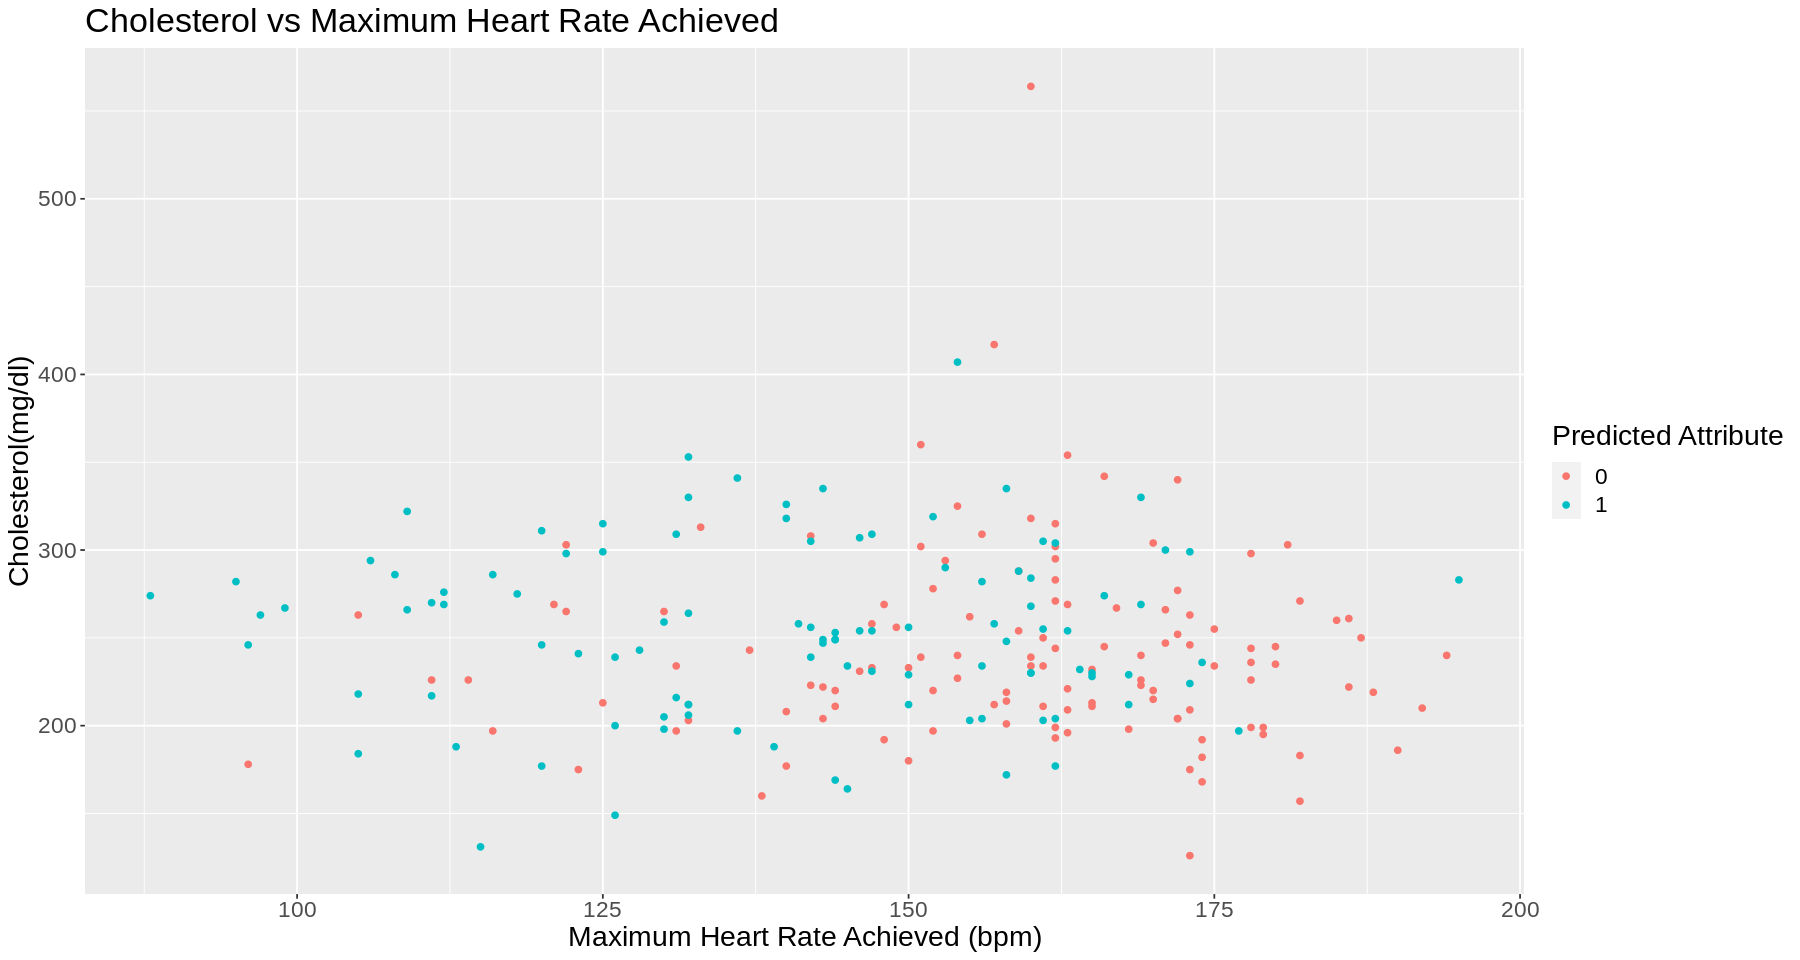

In [29]:
options(repr.plot.width = 15, repr.plot.height = 8) 

chol_v_hr_plot <- heart_data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Cholesterol(mg/dl)", colour = "Predicted Attribute") +
ggtitle("Cholesterol vs Maximum Heart Rate Achieved") +
theme(text=element_text(size=17))

chol_v_hr_plot

From the scatterplot, there does not seem to be any relationship between the two variables, Cholesterol and Maximum Heart Rate Achieved. However, we can observe that the most of the red points lie between a heart rate of 150-200 bpm and the most of the blue points lie between 100-150 bpm. So, people without heart disease seem to have a higher heart rate than the people with heart disease (on average).

We do 10 vfold cross-validation for our training data, and we find the best neighbor number for kknn from 1 to 50. We also do scale for data.

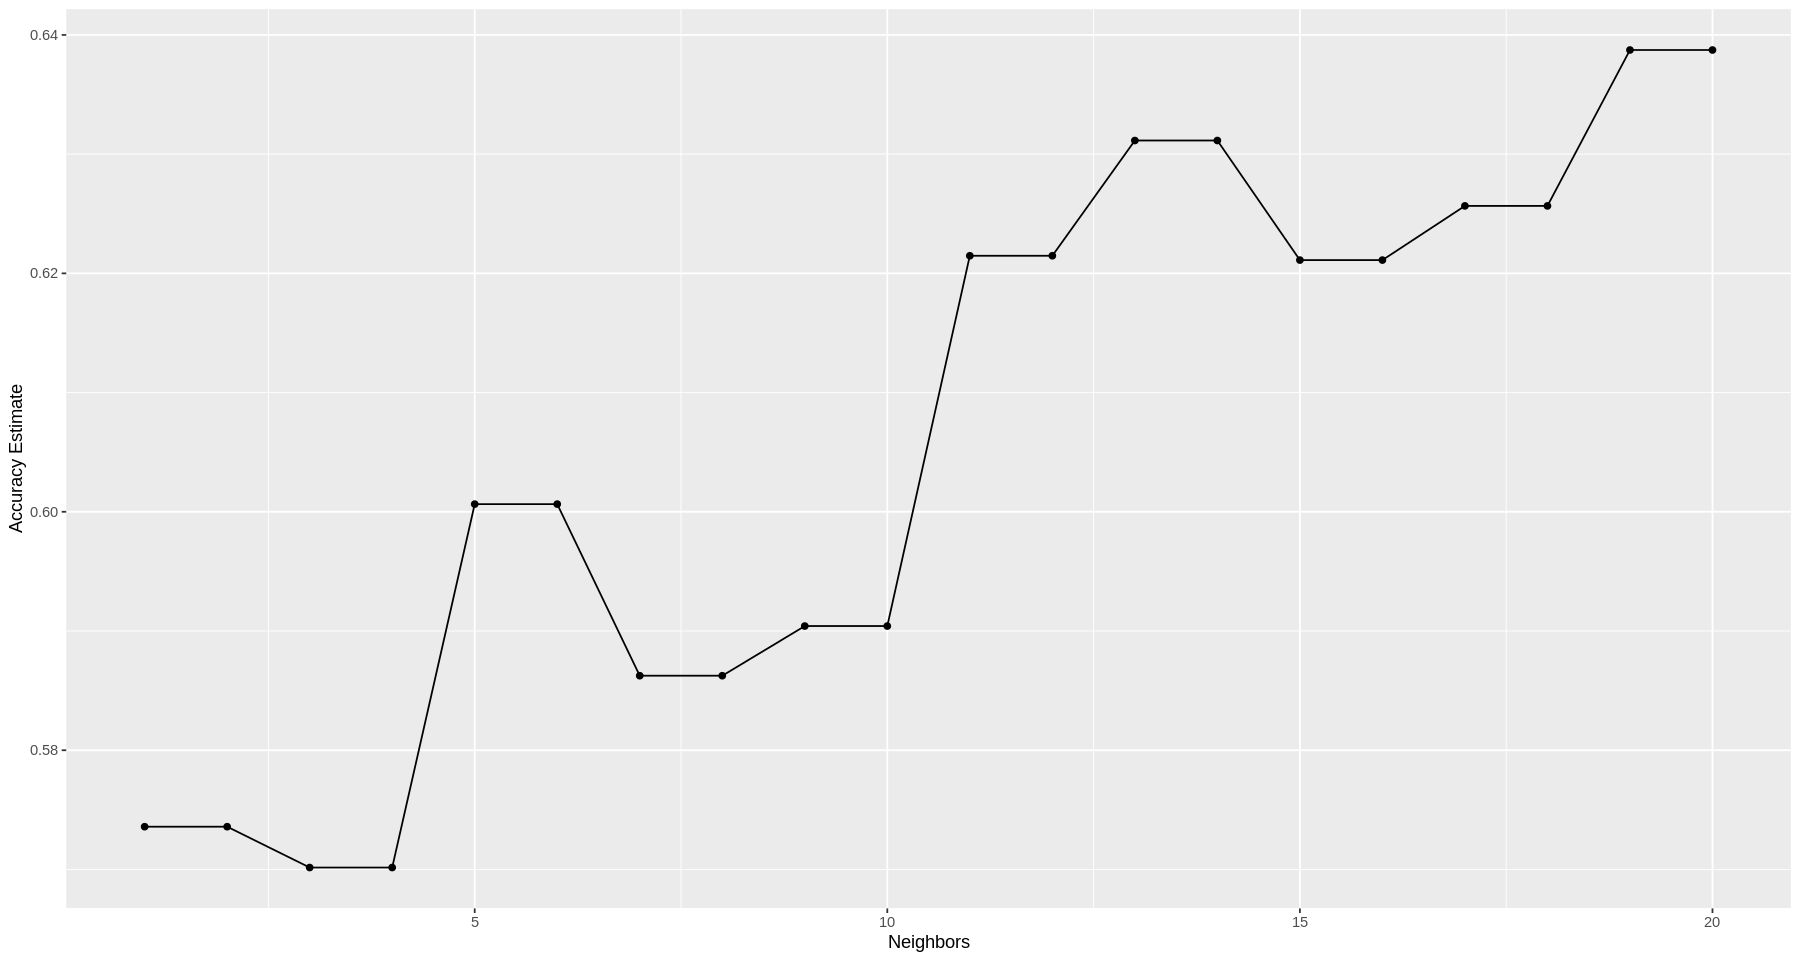

In [30]:
heart_vfold <- vfold_cv(heart_data_train, v = 10, strata = num_the_predicted_attribute)
knn_recipe <- recipe(num_the_predicted_attribute ~ ., data = heart_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
gridvals <- tibble(neighbors = 1:20)
results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()
accuracies <- results |>
      filter(.metric == "accuracy")
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

From this graph we can see neighbors = 16 should be a good choice because........
So, we will use neighbors = 16.

In [36]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) |>
      set_engine("kknn") |>
      set_mode("classification")
heart_fit <- workflow() |>
      add_recipe(knn_recipe) |>
      add_model(knn_spec) |>
      fit(data = heart_data_train)

heart_test_predictions <- predict(heart_fit , heart_data_test) |>
      bind_cols(heart_data_test)

heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = num_the_predicted_attribute, estimate =.pred_class )  
heart_prediction_accuracy

heart_mat <- heart_test_predictions |> 
      conf_mat(truth = num_the_predicted_attribute, estimate =.pred_class)
heart_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
kap,binary,0.4681596


          Truth
Prediction  0  1
         0 32 11
         1  9 24

Here is our predict result and confusion matrix.